In [1]:
import os
import flopy
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
from ipywidgets import interact
import numpy as np

In [2]:
from flopy.utils.triangle import Triangle as Triangle

In [3]:
workspace = 'Results'
tri_exe_name = '/home/harsh/Desktop/modflow_flopy/flopyCourse/triangle'

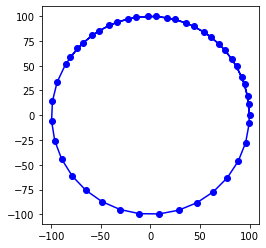

In [4]:
theta = np.arange(0., 2**np.pi, 0.2)
radius = 100.
x = radius * np.cos(theta)
y = radius * np.sin(theta)
circle_poly = [(x,y) for x, y in zip(x,y)]
ax = plt.subplot(aspect='equal')
ax.plot(x,y, 'bo-')

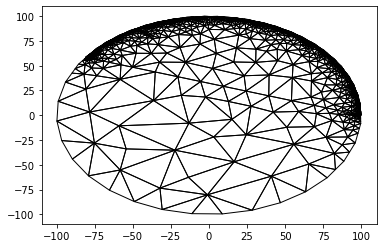

In [8]:
tri = Triangle(maximum_area=1000, angle=30, model_ws= workspace,
              exe_name=tri_exe_name)
tri.add_polygon(circle_poly)
tri.build(verbose=False)

fig, ax = plt.subplots()
pc = tri.plot(ax=ax)

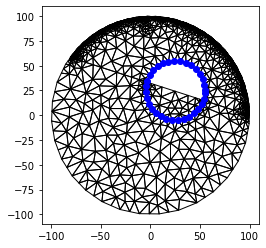

In [10]:
theta = np.arange(0., 2*np.pi, .2)
radius = 30.
x = radius * np.cos(theta) + 25
y = radius * np.sin(theta) + 25
inner_circle_poly = [(x, y) for x,y in zip(x,y)]

ax = plt.subplot(aspect='equal')
ax.plot(x,y, 'bo-')

tri = Triangle(maximum_area=100, angle=30, model_ws= workspace,
              exe_name=tri_exe_name)
tri.add_polygon(circle_poly)
tri.add_polygon(inner_circle_poly)
tri.add_hole((25,25))
tri.build(verbose=False)

# fig, ax = plt.subplots()
pc = tri.plot(ax=ax)

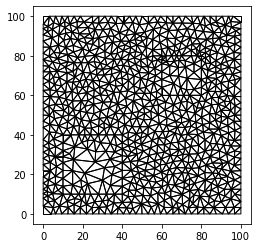

In [15]:
active_domain = [(0,0), (100,0), (100,100), (0,100)]
area1 = [(10,10), (40,10), (40,40), (10,40)]
area2 = [(60,60), (80,60), (80,80), (60,80)]
tri = Triangle(angle=30, model_ws=workspace, exe_name=tri_exe_name)
tri.add_polygon(active_domain)
tri.add_polygon(area1)
tri.add_polygon(area2)
tri.add_region((1,1),0,maximum_area=10)
tri.build(verbose=False)
ax = plt.subplot(aspect='equal')
tri.plot(ax=ax)

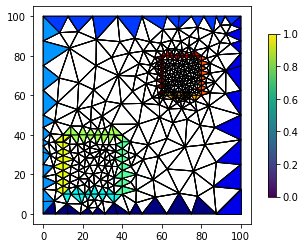

In [19]:
active_domain = [(0,0), (100,0), (100,100), (0,100)]
area1 = [(10,10), (40,10), (40,40), (10,40)]
area2 = [(60,60), (80,60), (80,80), (60,80)]
tri = Triangle(angle=30, model_ws=workspace, exe_name=tri_exe_name)
tri.add_polygon(active_domain)
tri.add_polygon(area1)
tri.add_polygon(area2)
tri.add_region((1,1),0,maximum_area=100)
tri.add_region((11,11),1,maximum_area=10)
tri.add_region((61,61),2,maximum_area=3)
tri.build(verbose=False)
ax = plt.subplot(aspect='equal')
tri.plot(ax=ax)

ibd = tri.get_boundary_marker_array()
ibd = np.ma.masked_equal(ibd,0)
tri.plot(ax=ax, a=ibd, cmap='jet')
plt.colorbar(pc, shrink=0.75)

In [22]:
## Flopy exercise

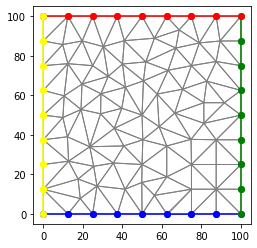

In [25]:
active_domain = [(0,0), (100,0), (100,100), (0,100)]
tri = Triangle(angle=30, maximum_area=100,
              model_ws=workspace, exe_name=tri_exe_name)
tri.add_polygon(active_domain)
tri.build()
ax = plt.subplot(aspect='equal')
tri.plot(edgecolor='gray')
for ibm in [1,2,3,4]:
    color = ['blue', 'green', 'red', 'yellow']
    tri.plot_boundary(ibm, ax, marker='o', color=color[ibm-1])

In [27]:
name = 'mf'
sim = flopy.mf6.MFSimulation(sim_name=name, version = 'mf6',
                            exe_name='/home/harsh/Desktop/modflow_flopy/flopyCourse/mf6',
                            sim_ws = workspace)

In [28]:
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS', perioddata=[1, 1, 1])

In [29]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

In [30]:
ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                          complexity='complex',
                          outer_hclose=1.e-8,
                          inner_hclose=1.e-8)

In [31]:
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
xcyc = tri.get_xcyc()
nlay = 1
ncpl = tri.ncpl
nvert = tri.nvert
top = 1
botm = [0]
dis = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, nvert=nvert,
                              top=top, botm=botm, vertices=vertices,
                              cell2d=cell2d)

In [32]:
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[(True)])

In [34]:
ic = flopy.mf6.ModflowGwfic(gwf)

In [35]:
def chdhead(x):
    return(x*10/100)

chdlist = []
leftcells = tri.get_edge_cells(4)
rightcells = tri.get_edge_cells(2)
for icpl in leftcells + rightcells:
    h = chdhead(xcyc[icpl,0])
    chdlist.append([(0,icpl), h])

chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)

In [39]:
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=name+'.cbc',
                            head_filerecord=name+'.hds',
                            saverecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')])
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd_0...
    writing package oc...
FloPy is using the following  executable to run the model: /home/harsh/Desktop/modflow_flopy/flopyCourse/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

  MODFLOW 6 compiled May  4 2021 17:51:29 with GFORTRAN compiler (ver. 9.3.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to th

(True, [])

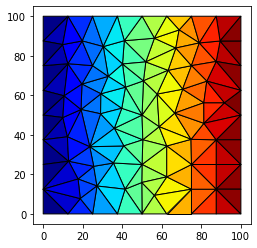

In [41]:
fname = os.path.join(workspace, name+'.hds')
hdobj = flopy.utils.HeadFile(fname, precision='double')
head = hdobj.get_data()

ax = plt.subplot(aspect = 'equal')
tri.plot(ax = ax, a = head[0,0,:], cmap='jet')